# Anomaly Detection

## 데이터 구하기
- Open, High, Low, Close, Adj Close, Volumn: 시가, 고가, 저가, 종가, 보정종가, 거래량

In [2]:
import pandas as pd
import os
csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/NQ=F.csv'

df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-27,8048.0,8062.75,8048.0,8058.00,8058.00,474887.0
1,2019-10-28,8048.0,8127.50,8048.0,8094.75,8094.75,309114.0


In [3]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date          0
Open         10
High         10
Low          10
Close        10
Adj Close    10
Volume       10
dtype: int64

In [4]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 304
삭제 후 데이터 길이(일자수): 294


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


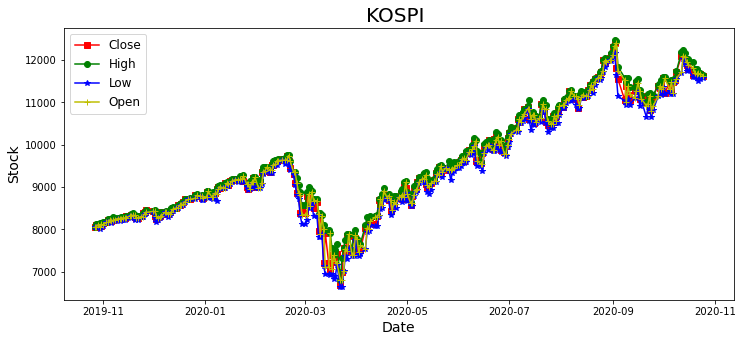

In [5]:
# 분포 그리기
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('KOSPI ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

## 기본 통계분석으로 이상치 찾기
- 분포 그리기
- z-test로 정규분포 만족하는지 확인 (만족안하면 times series decompose -> residual 분석)
- 왜 이상치로 분류되었는지
- 이상치는 outlier인지 novelties인지
- 이상치 제거/교정할지 그냥둘지 고민

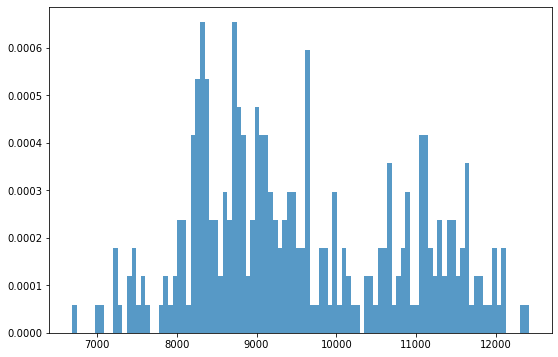

In [8]:
# 분포 그리기
%matplotlib inline
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

In [9]:
# z-test => normal distribution (x)
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home/aiffel0036/anaconda3

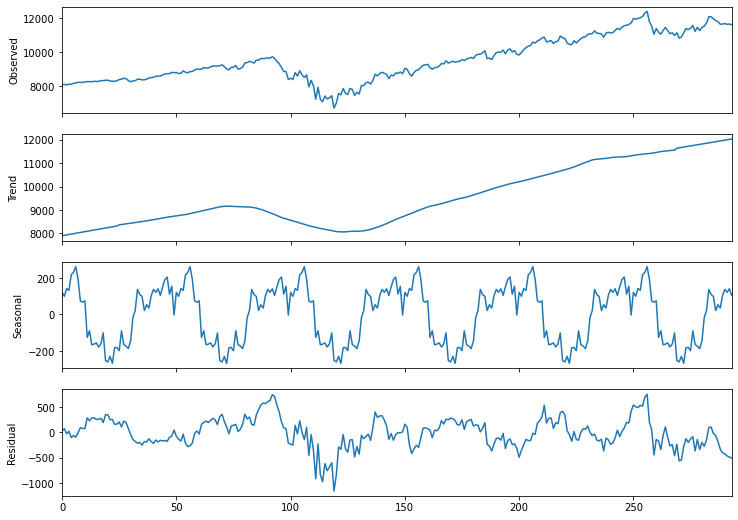

In [11]:
#그래프가 너무 작아서 안보인다면

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

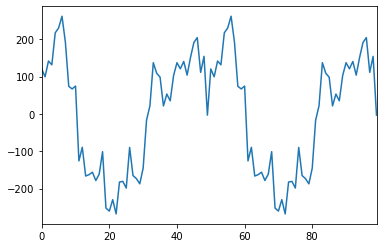

In [12]:
# seasonal 성분은 너무 빼곡하게 보이네요. 다시 확인해보겠습니다.
result.seasonal[:100].plot()
#-8 에서 10 사이를 주기적으로 반복하는게 보이네요.

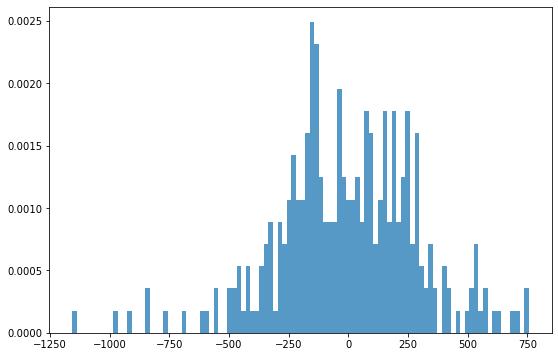

In [13]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [14]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.5109744443518943 0.609368951624285


In [15]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -8.784586595519098 표준편차: 294.77850602342755
이상치 갯수: 3


In [16]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

111   2020-03-12
114   2020-03-16
119   2020-03-22
Name: Date, dtype: datetime64[ns]

## Unsupervised Clustering으로 이상치 찾기
- k-means
- DBSCAN
- 왜 이상치로 분류되었는지
- 이상치는 outlier인지 novelties인지
- 이상치 제거/교정할지 그냥둘지 고민

In [20]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,294.000000,294.000000,294.000000,294.000000,294.000000
mean,9537.274721,9652.165796,9428.288023,9555.410747,509443.742130
std,1273.714897,1283.091358,1261.325283,1273.597028,146021.605603
min,7892.155965,7914.872777,7838.135000,7909.060733,123942.697421
25%,8460.703125,8568.300649,8372.358125,8478.064299,476422.795000
50%,9119.936250,9203.242500,9028.897500,9128.461001,521572.045000
75%,10684.768035,10793.368379,10577.932266,10707.250151,561116.865817
max,12033.042071,12196.758183,11862.766066,12040.730510,776809.340000


In [21]:
rdf.describe()

,Open,High,Low,Close,Volume
count,294.000000,294.000000,294.000000,294.000000,294.000000
mean,-8.702225,-9.819351,-8.119068,-9.924515,12200.352326
std,305.364890,277.607017,310.624542,295.414984,199245.777419
min,-1087.381891,-1265.323452,-1039.629586,-1156.742686,-493776.014925
25%,-183.923229,-181.371367,-202.778027,-178.141983,-120785.753704
50%,-6.915647,-27.411247,-16.260352,-16.721501,-21817.065250
75%,192.321052,184.156923,209.537422,192.341837,133032.323496
max,775.712209,709.312335,762.103948,755.328367,697957.466326


In [22]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[-8.70222451e+00 -9.81935132e+00 -8.11906786e+00 -9.92451519e+00
  1.22003523e+04]


array([[ 0.47584694,  0.31065471,  0.32347742,  0.12962841,  0.8406826 ],
       [ 0.13627017,  0.346654  ,  0.2635416 ,  0.26694816,  0.02286107],
       [ 0.37007899,  0.21353733,  0.1439037 , -0.06811745,  0.67426553],
       ...,
       [-1.40466264, -1.71753945, -1.60761112, -1.58421876,  0.77820542],
       [-1.54693545, -1.99663009, -1.55294341, -1.66044237,  1.18172907],
       [-1.73239656, -2.25864167, -1.39152516, -1.72839309, -2.04332795]])

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1]


In [24]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl) # 0번 그룹, 1번 그룹으로 나뉘어졌네요
print(cnt)

[0 1]
[138 156]


In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:25',
 'group:1-count:25',
 'group:2-count:14',
 'group:3-count:9',
 'group:4-count:36',
 'group:5-count:31',
 'group:6-count:31',
 'group:7-count:18',
 'group:8-count:7',
 'group:9-count:29',
 'group:10-count:8',
 'group:11-count:6',
 'group:12-count:31',
 'group:13-count:10',
 'group:14-count:14']

In [28]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==3)|(kmeans.labels_==8)|(kmeans.labels_==10)|(kmeans.labels_==11)]

,Date,Open,High,Low,Close,Adj Close,Volume
86,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
87,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
88,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
89,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0
90,2020-02-16,9635.000000,9668.750000,9634.250000,9663.750000,9663.750000,297278.0
91,2020-02-18,9635.000000,9687.500000,9534.250000,9636.000000,9636.000000,668505.0
92,2020-02-19,9643.250000,9748.750000,9641.250000,9733.500000,9733.500000,419130.0
93,2020-02-20,9744.750000,9763.000000,9517.000000,9624.250000,9624.250000,802424.0
94,2020-02-21,9617.250000,9623.750000,9411.500000,9458.000000,9458.000000,911839.0
99,2020-02-27,8811.500000,8878.500000,8334.250000,8382.750000,8382.750000,1580041.0


In [26]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,294.000000,294.000000,294.000000,294.000000,294.000000,2.940000e+02
mean,9525.243373,9639.550203,9416.720580,9542.715785,9542.715785,5.211183e+05
std,1305.557276,1297.944343,1305.641435,1302.412480,1302.412480,2.588664e+05
min,6798.000000,6798.000000,6628.750000,6688.750000,6688.750000,1.701500e+04
25%,8490.500000,8600.562500,8397.750000,8504.937500,8504.937500,3.746300e+05
50%,9194.750000,9313.125000,9124.250000,9233.250000,9233.250000,4.802615e+05
75%,10698.250000,10829.175049,10549.950195,10681.200195,10681.200195,6.110548e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [29]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인해보겠습니다.
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,-0.069400,-0.164415,-0.318731,-0.355706,0.964708
1,0.958350,0.968884,0.941986,0.894348,0.239908
2,-1.243878,-1.604338,-1.340221,-1.550249,1.040833
3,1.651495,1.685105,1.934167,1.863490,-1.020041
4,-0.677629,-0.664278,-0.611207,-0.609530,-0.839199
5,-0.146578,-0.155675,-0.094643,-0.086082,-0.362152
6,0.389024,0.420606,0.421264,0.408653,0.530495
7,1.128305,1.071618,0.936175,0.838867,1.508306
8,-2.591614,-2.495424,-2.894826,-2.806005,-1.644782
9,-0.726455,-0.704969,-0.744989,-0.715939,0.077395


In [30]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [31]:
# 분류된 라벨들은 이렇게 확인할 수 있어요
print(clustering.labels_)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  2  2  2  2  2 -1  3  2 -1
 -1  4  4  5  6  6 -1  4  0  0  0  0 -1  7  0 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 -1  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  9 -1  0  0
  0  0  8  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0
  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  2  2  2  2  2  2  3 -1 -1 -1  7  0  0  0
  0  1  0  8  8  7 -1 -1  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0
  0  9  8  8  8 -1]


In [32]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:32',
 'group:0-count:225',
 'group:1-count:2',
 'group:2-count:13',
 'group:3-count:2',
 'group:4-count:4',
 'group:5-count:2',
 'group:6-count:2',
 'group:7-count:3',
 'group:8-count:7',
 'group:9-count:2']

## LSTM Autoencoder로 이상치 찾기
- 딥러닝 위한 데이터셋 구성
- 오토인코더 모델 생성
- 학습 정상 수행되었는지 확인
- 방법들 비교
- 왜 다른지 확인
- 오토인코더 모델 개선

In [33]:
# 필요한 라이브러리를 불러옵니다

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [34]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [35]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [36]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [37]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [38]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜본다

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [39]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 1.3869 - mae: 1.3869
Epoch 00001: val_loss improved from inf to 2.76482, saving model to /home/aiffel0036/aiffel/anomaly_detection/kospi/mymodel.ckpt
9/9 [==============================] - 1s 63ms/step - loss: 1.3869 - mae: 1.3869 - val_loss: 2.7648 - val_mae: 2.7648
Epoch 2/50
8/9 [=========================>....] - ETA: 0s - loss: 1.1531 - mae: 1.1531
Epoch 00002: val_loss improved from 2.76482 to 1.92156, saving model to /home/aiffel0036/aiffel/anomaly_detection/kospi/mymodel.ckpt
9/9 [==============================] - 0s 28ms/step - loss: 1.2630 - mae: 1.2630 - val_loss: 1.9216 - val_mae: 1.9216
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 0.9861 - mae: 0.9861
Epoch 00003: val_loss improved from 1.92156 to 1.29477, saving model to /home/aiffel0036/aiffel/anomaly_detection/kospi/mymodel.ckpt
9/9 [==============================] - 0s 27ms/step - loss: 0.9861 - mae: 0.9861 - val_loss: 1.2948 - val_ma

Epoch 29/50
8/9 [=========================>....] - ETA: 0s - loss: 0.3175 - mae: 0.3175
Epoch 00029: val_loss improved from 0.28552 to 0.28491, saving model to /home/aiffel0036/aiffel/anomaly_detection/kospi/mymodel.ckpt
9/9 [==============================] - 0s 28ms/step - loss: 0.3077 - mae: 0.3077 - val_loss: 0.2849 - val_mae: 0.2849
Epoch 30/50
8/9 [=========================>....] - ETA: 0s - loss: 0.2553 - mae: 0.2553
Epoch 00030: val_loss improved from 0.28491 to 0.27987, saving model to /home/aiffel0036/aiffel/anomaly_detection/kospi/mymodel.ckpt
9/9 [==============================] - 0s 28ms/step - loss: 0.2858 - mae: 0.2858 - val_loss: 0.2799 - val_mae: 0.2799
Epoch 31/50
8/9 [=========================>....] - ETA: 0s - loss: 0.3039 - mae: 0.3039
Epoch 00031: val_loss improved from 0.27987 to 0.27252, saving model to /home/aiffel0036/aiffel/anomaly_detection/kospi/mymodel.ckpt
9/9 [==============================] - 0s 28ms/step - loss: 0.2949 - mae: 0.2949 - val_loss: 0.2725 -

In [40]:
model.load_weights(checkpoint_path)

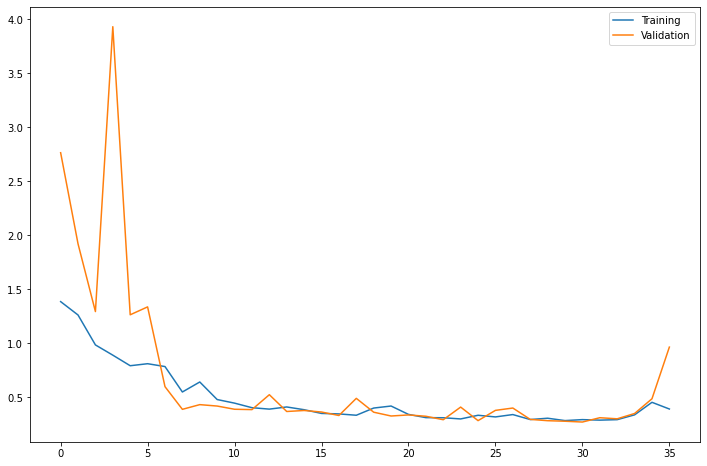

In [41]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

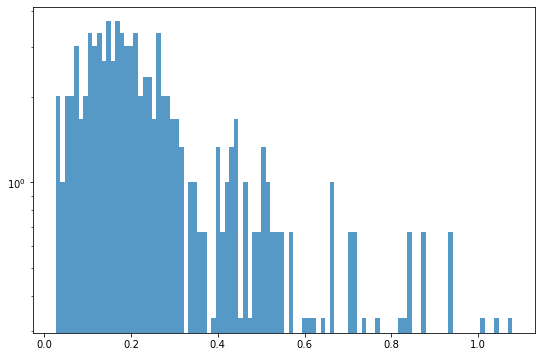

In [42]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [43]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 1
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
89,2020-02-27,8811.50,8878.5,8334.25,8382.75,8382.75,1580041.0,1.012246
93,2020-03-03,8830.50,9002.5,8511.00,8582.50,8582.50,1295648.0,1.043674
101,2020-03-12,7998.75,8108.0,7128.50,7215.25,7215.25,876291.0,1.079552


In [44]:
threshold = 0.5
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
62,2020-01-26,9077.000000,9077.000000,8994.000000,9004.500000,9004.500000,875259.0,0.516680
85,2020-02-23,9355.250000,9365.000000,9289.000000,9315.000000,9315.000000,995989.0,0.598742
86,2020-02-24,9355.250000,9365.000000,9041.250000,9091.000000,9091.000000,1171879.0,0.660778
87,2020-02-25,9091.000000,9224.250000,8810.000000,8854.250000,8854.250000,1344897.0,0.769468
88,2020-02-26,8868.250000,9037.500000,8709.500000,8850.250000,8850.250000,1251412.0,0.606118
89,2020-02-27,8811.500000,8878.500000,8334.250000,8382.750000,8382.750000,1580041.0,1.012246
90,2020-02-28,8347.000000,8574.750000,8126.250000,8454.000000,8454.000000,1527204.0,0.933466
91,2020-03-01,8347.000000,8574.750000,8126.250000,8382.750000,8382.750000,1513887.0,0.872761
92,2020-03-02,8349.250000,8883.250000,8224.250000,8791.250000,8791.250000,1373357.0,0.936177
93,2020-03-03,8830.500000,9002.500000,8511.000000,8582.500000,8582.500000,1295648.0,1.043674


/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


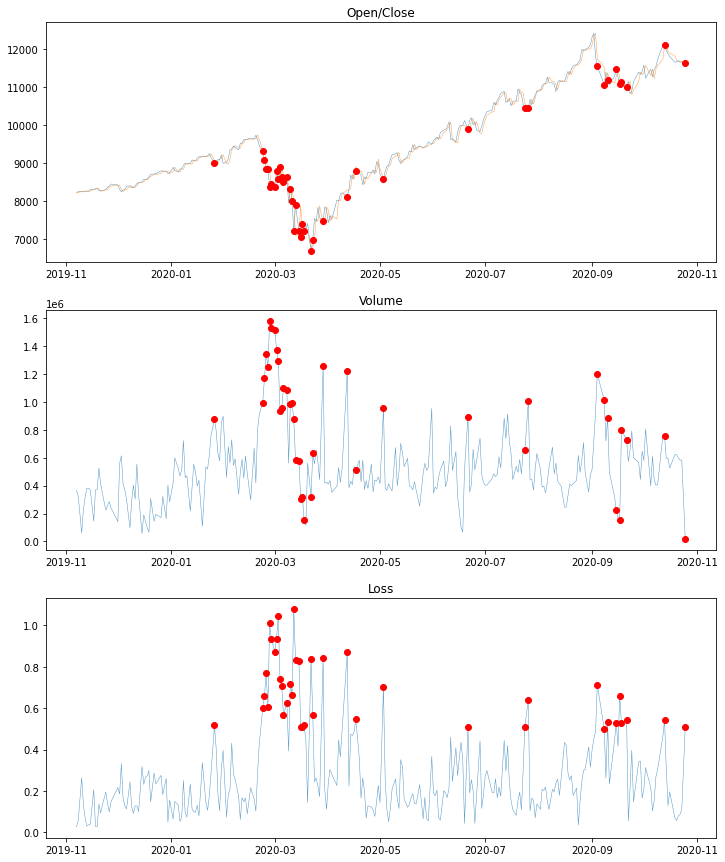

In [45]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])